# Building decision trees for classification

We have discussed in the lecture how decision trees can be used for both classification and regression tasks. In this first example, we will build one for the classification of a binary outcome - churn.

Churn refers to whether a customer turns away from a company. It's an important measure that companies are interested in both assessing and predicting. For example, they might want to target customers who they think might "leave" with additional advertisting to keep them, or they might want to stop spending money on them early because they don't want to "waste" expenses on a customer who will leave anyway. In real life, you will often not only classify customers by their churn likelihood, but co-analyse churn in combination with profitability.

## Dataset

In [1]:
##### added line to ensure plots are showing
%matplotlib inline
#####

import pandas as pd
import numpy as np

# Import your dataset and plot a few lines of it

df = pd.read_csv('churn_ibm.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


We see various variables, both demographic ones (Partner (Yes/No), tenure (length of contract), gender, etc.), as well as service-related variables (DeviceProtection, PaymentMethod, Contact, MonthlyCharges, etc.). All variables are relatively self-explanatory.

Our outcome variable "Churn" is in the last column. You might want to start with some descriptive statistics to get a feel for the data. How many customers will turn away from the company? What is the overall split between different demographic categories? What's the distribution of their charges (profitability?)?

Let's split the data into independent and dependent parts.

Customer ID is just an identifier and can not be used to predict anything, so we drop it.

In [2]:
y = df['Churn']
X = df.drop(['Churn','customerID'],axis=1)

Something else we should consider is that the implementation in Python can only deal with numeric variables (i.e. not "strings"). You will remember from the lecture that we talked about how trees can handle different data types well in theory, but for implementation purposes we use dummy variables here. 

This allows the tree to do its binary splitting.

Checking data types is good practice in general - it can also highlight problems that you might encounter with your data, for example if a variable has been loaded in incorrectly.

In [3]:
X.dtypes # checks data types

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

It appears there are a lot of categorical variables of type 'object'. Let's convert those to dummy variables here.

In [4]:
for column in X.columns:
    if X[column].dtype == object:
        print('Converting ', column)
        X = pd.concat([X,pd.get_dummies(X[column], prefix=column, drop_first=True)],axis=1).drop([column],axis=1)

Converting  gender
Converting  Partner
Converting  Dependents
Converting  PhoneService
Converting  MultipleLines
Converting  InternetService
Converting  OnlineSecurity
Converting  OnlineBackup
Converting  DeviceProtection
Converting  TechSupport
Converting  StreamingTV
Converting  StreamingMovies
Converting  Contract
Converting  PaperlessBilling
Converting  PaymentMethod


The dependent variable is also categorical. This is fine because we are predicting a categorical outcome with out classification tree versus a regression tree which would need a numerical outcome. We convert it to a dummy variable here to get a 0/1 outcome.

In [5]:
y = pd.get_dummies(y, prefix='churn', drop_first=True)
y.head()

,churn_Yes
0,0
1,0
2,1
3,0
4,1


## Building the tree

We can very easily construct our decision tree without changing any parameters using a training and test set as usual. In the lecture we talked about how there is no need to scale the variables (which would be impossible with categorical ones anyway).

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

decision_tree = DecisionTreeClassifier()

# Check out the parameters in the documentation:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

# The default setting for the splitting criterion is the Gini index.

# What happens when you pick entropy instead?

# Another interesting attribute is min_samples_leaf (how many observations do you want in your leaves?)

decision_tree.fit(X_train,y_train)
prediction = decision_tree.predict(X_test)

print('Accuracy:', accuracy_score(y_test,prediction))
print('AUC:',roc_auc_score(y_test,prediction))

Accuracy: 0.7265402843601896
AUC: 0.6583847457177492


Our tree has the following size:

In [7]:
print('Number of nodes:', decision_tree.tree_.node_count)

Number of nodes: 1933


We can also plot the AUC curve as a measure of performance. Remember that AUC is a comparative measure. We can use it to compare between models. You'll want it to be further away from the a 45 degree line, which is to say, better than random.

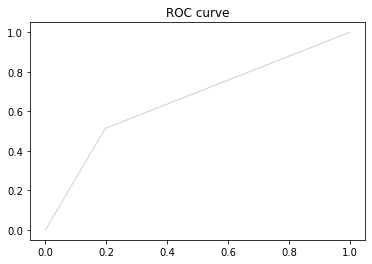

In [9]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, prediction)
plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC')
plt.title('ROC curve')
plt.show()

Here is an example of how you can adjust the tree based on some things that we talked about in the lecture.

For example, a tree with a max depth of 3 and a minimum of 10 samples per leaf. This time, we also use entropy/information gain instead of Gini index:

In [10]:
decision_tree2 = DecisionTreeClassifier(max_depth=3,min_samples_leaf=10,criterion='entropy')
decision_tree2.fit(X_train,y_train)
prediction = decision_tree2.predict(X_test)

print('Accuracy:', accuracy_score(y_test,prediction))
print('AUC:',roc_auc_score(y_test,prediction))
print('Number of nodes:', decision_tree2.tree_.node_count)

Accuracy: 0.7578199052132701
AUC: 0.7174187349842965
Number of nodes: 15


Both our accuracy and AUC are up, possibly due to less overfitting with having a smaller tree with less leaves. You will remember that decision trees are prone to overfitting, so this is not surprising.

## Visualising the tree

We can also easily visualise our tree by using the following code. The first tree was too big, so we're plotting the second one for which we improved complexity.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 KB 6.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=3ad58a6dc9039e3d99817ec77320024379bcda5c2324136a754d539ada74d56d
  Stored in directory: /home/jovyan/.cache/pip/wheels/89/e5/de/6966007cf223872eedfbebbe0e074534e72e9128c8fd4b55eb
Successfully built pydotplus


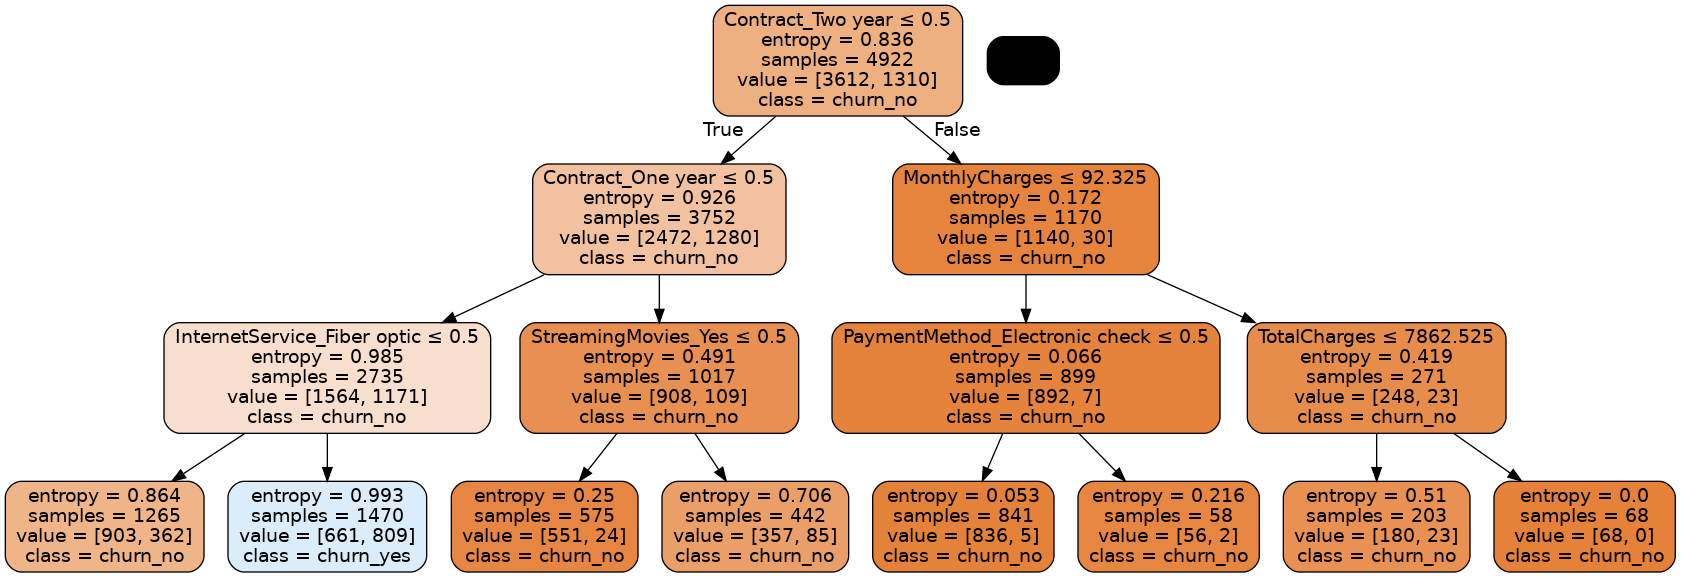

In [11]:
!pip install pydotplus
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

# create a file to store the figure in
dot_data = StringIO()

export_graphviz(decision_tree2, out_file=dot_data,  
                filled=True, rounded=True,class_names=['churn_no','churn_yes'],
                special_characters=True,feature_names=X.columns)

# import and display the figure
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

The value list gives us the number of each class present in each of the leaves. We can see that most leaves predict that churn_yes=0 which means that no churn occurs.

Have a look at the different variables used for the splitting.

Unfortunately, scikit-learn does not offer any pruning capabilities (yet). So, the only way to force simplicity is by working with the tree depth as a parameter. 